# Anomaly detection pipeline for Credit Card transactions


The provided dataset show us data from 9 companies and the goal here is to define a transformation pipeline to reveal users that shows anomalies in its behaviour.

This notebook consists on data transformation after its extraction, from an API, for example. The process is basically convert several JSON files that contains credit card transaction logs of one company into a pandas dataframe, and make the procedure reproductible to other companies data.

With pandas dataframe set, we going to grab informations from each user, such as credit card usage and transaction velocity, to detect anomalies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import os
import json

In [2]:
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
DATA_DIR = os.path.join(BASE_DIR, "credit_00")
FILES = os.listdir(DATA_DIR)

## 0. First Steps

### 0.1 Making a Pandas Dataframe to Analyze

In [3]:
#DEALS WITH JSON FORMAT: TRANSFORM A DICT LINES {}{}...{} TO [{},{},...,{}]
#THEN CONVERT INTO A PANDAS DATAFRAME
%%time
print('Converting files into a pandas dataframe...', end="")
json_list = []
for file in FILES:

  #get only json files
  if file[-4:] == 'json': 
    
    jsonify_file = []
    #read each line and append to a list
    for line in open(os.path.join(DATA_DIR, file), 'r'): 
      
      jsonify_file.append(json.loads(line))

    tmp = pd.DataFrame(jsonify_file)

    json_list.append(tmp)

df = pd.concat(json_list)
print('ok')

Converting files into a pandas dataframe...ok
CPU times: user 34.1 s, sys: 2.58 s, total: 36.7 s
Wall time: 36.8 s


In [4]:
#delete previous list to clean memory
del json_list
del jsonify_file
del tmp

In [5]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100000 entries, 0 to 4099999
Data columns (total 7 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   number                object
 1   security_code         object
 2   dt_current_timestamp  object
 3   user_id               int64 
 4   provider              object
 5   expire_data           object
 6   uuid                  object
dtypes: int64(1), object(6)
memory usage: 219.0+ MB


Due to large dataset (7+gb), i'll try to optimize memory usage by converting variable type to a more efficient one.

In [6]:
df['dt_current_timestamp'] = pd.to_datetime(df['dt_current_timestamp'],format="%Y-%m-%d %H:%M:%S.%f")
df['expire_data'] = pd.to_datetime(df['expire_data'], format="%m/%y")
df['security_code'] = df['security_code'].astype('uint32', copy=False)
df['number'] = df['number'].astype('int64', copy=False)

In [7]:
df = df.sort_values(by='dt_current_timestamp')

In [8]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100000 entries, 0 to 4099999
Data columns (total 7 columns):
 #   Column                Dtype         
---  ------                -----         
 0   number                int64         
 1   security_code         uint32        
 2   dt_current_timestamp  datetime64[ns]
 3   user_id               int64         
 4   provider              object        
 5   expire_data           datetime64[ns]
 6   uuid                  object        
dtypes: datetime64[ns](2), int64(2), object(2), uint32(1)
memory usage: 203.3+ MB


In [9]:
df.head()

,number,security_code,dt_current_timestamp,user_id,provider,expire_data,uuid
0,30068562987736,679,2020-12-02 16:38:56.787842,48596,American Express,2028-12-01,7c927627-c89d-4379-8bde-07289d6f33e0
1,676237296857,232,2020-12-02 16:38:56.788353,41626,Mastercard,2024-02-01,a5565183-f39a-44ab-8a39-b761c213ce4d
2,2270207598092278,570,2020-12-02 16:38:56.789360,98599,American Express,2024-06-01,a4aa6f88-b026-4ddf-b5ea-0c52c8609538
3,60467638148,818,2020-12-02 16:38:56.789513,83716,JCB 15 digit,2021-08-01,3774d30d-a79d-4016-b71f-1e33543d83e3
4,4851606755062599,224,2020-12-02 16:38:56.790990,67020,JCB 16 digit,2026-12-01,5876f871-1b35-4d6d-8218-8a55c105d605


### 0.2 - Creating basic visualizations and some basic features

In [10]:
df['days_to_expire'] = (df['expire_data'] - df['dt_current_timestamp']).dt.days

In [11]:
df['current_day'] = df['dt_current_timestamp'].dt.day
df['current_hour'] = df['dt_current_timestamp'].dt.hour
df['current_minute'] = df['dt_current_timestamp'].dt.minute
df['current_second'] = df['dt_current_timestamp'].dt.second
df['current_microsecond'] = df['dt_current_timestamp'].dt.microsecond
df['day_of_week'] = df['dt_current_timestamp'].dt.dayofweek

In [12]:
PROVIDER_MAP = {
    'VISA 16 digit':'visa_16',
    'American Express':'american_express',
    'JCB 15 digit':'JCB_15',
    'JCB 16 digit':'JCB_16',
    'Diners Club / Carte Blanche':'diners_club',
    'VISA 13 digit':'visa_13',
    'VISA 19 digit':'visa_19'
}

In [13]:
df['provider'] = df['provider'].replace(PROVIDER_MAP)

In [14]:
df.tail()

,number,security_code,dt_current_timestamp,user_id,provider,expire_data,uuid,days_to_expire,current_day,current_hour,current_minute,current_second,current_microsecond,day_of_week
4099995,568039623828,292,2020-12-11 18:50:31.949111,56538,visa_19,2025-02-01,f2415b9b-977b-4df2-b8e6-761d323f97ad,1512,11,18,50,31,949111,4
4099996,4339704135191,80,2020-12-11 18:50:31.949268,56889,JCB_15,2021-07-01,3f8b3b35-6cf3-4400-bc2e-722c38d679de,201,11,18,50,31,949268,4
4099997,3553664337475204,364,2020-12-11 18:50:31.949937,27487,JCB_16,2029-08-01,d69377ab-ca81-46c2-bb65-ebbc57d36d01,3154,11,18,50,31,949937,4
4099998,4354526339063438,500,2020-12-11 18:50:31.952025,95644,visa_19,2022-01-01,3584de0b-6d2c-4f74-94c8-346a0d1449e8,385,11,18,50,31,952025,4
4099999,38355987175290,340,2020-12-11 18:50:31.952192,13843,JCB_16,2027-05-01,38795793-3adc-429b-92fb-3493ac7f6f76,2331,11,18,50,31,952192,4


In [15]:
df.to_csv(os.path.join(BASE_DIR, "dataframe.csv"), index=False)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100000 entries, 0 to 4099999
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   number                int64         
 1   security_code         uint32        
 2   dt_current_timestamp  datetime64[ns]
 3   user_id               int64         
 4   provider              object        
 5   expire_data           datetime64[ns]
 6   uuid                  object        
 7   days_to_expire        int64         
 8   current_day           int64         
 9   current_hour          int64         
 10  current_minute        int64         
 11  current_second        int64         
 12  current_microsecond   int64         
 13  day_of_week           int64         
dtypes: datetime64[ns](2), int64(9), object(2), uint32(1)
memory usage: 422.3+ MB


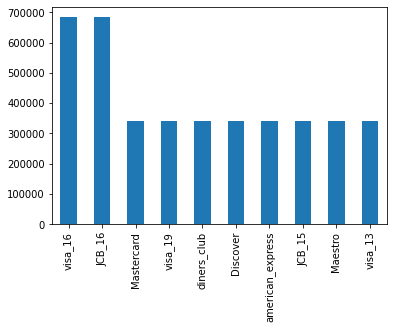

In [17]:
df['provider'].value_counts().plot(kind='bar');

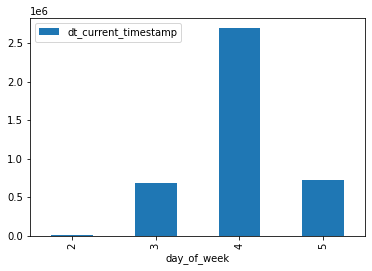

In [18]:
df[['dt_current_timestamp', 'day_of_week']].groupby('day_of_week').count().plot(kind='bar');

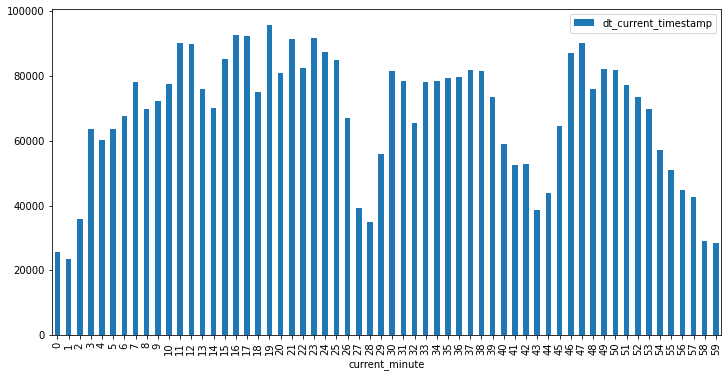

In [19]:
df[['dt_current_timestamp','current_minute']].groupby('current_minute').count().plot(kind='bar', figsize=(12,6));

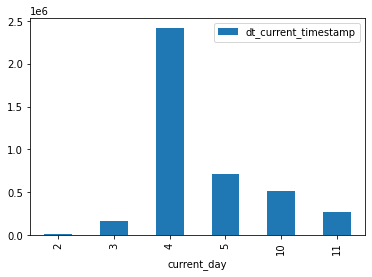

In [20]:
df[['dt_current_timestamp','current_day']].groupby('current_day').count().plot(kind='bar');

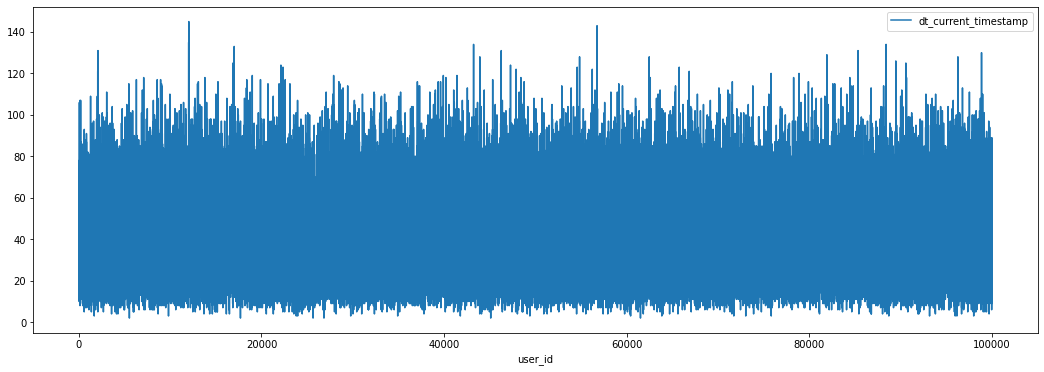

In [21]:
df[['dt_current_timestamp','user_id']].groupby('user_id').count().plot(figsize=(18,6));

### 0.3 Feature Engineering

In [22]:
#CREATE A USER DATAFRAME TO POSTERIOR CLUSTERIZATION
users_count = df[['dt_current_timestamp','user_id']].groupby('user_id').count()
users_count = users_count.reset_index()
users_count.columns = ['user_id', 'total_transactions']

In [23]:
users_count

,user_id,total_transactions
0,0,21
1,1,51
2,2,63
3,3,17
4,4,65
...,...,...
99995,99996,63
99996,99997,64
99997,99998,40
99998,99999,30


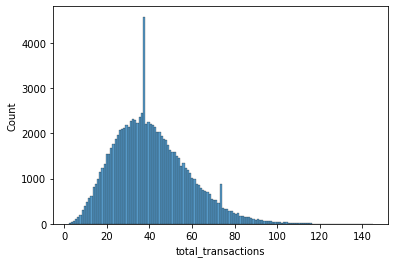

In [24]:
sns.histplot(users_count['total_transactions']);

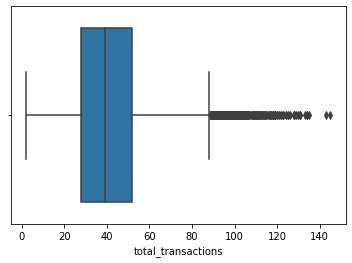

In [25]:
sns.boxplot(x=users_count['total_transactions']);

In [26]:
#Calculate interquartilic range for outlier detection
IQR = users_count['total_transactions'].quantile(0.75) - users_count['total_transactions'].quantile(0.25)

cs_iqr_inf_limit = users_count['total_transactions'].quantile(0.25) - (IQR * 1.5)
cs_iqr_sup_limit = users_count['total_transactions'].quantile(0.75) + (IQR * 1.5)

print('1st Quartile - 1.5 * DIR = {}'.format(cs_iqr_inf_limit))
print('3rd Quartile + 1.5 * DIR = {}\n'.format(cs_iqr_sup_limit))

1st Quartile - 1.5 * DIR = -8.0
3rd Quartile + 1.5 * DIR = 88.0



In [27]:
print('There are {} users with more than 88 transactions'.format(
    len([x for x in users_count['total_transactions'].tolist() if x > cs_iqr_sup_limit])))

print('There are {} users with less than -8 transactions'.format(
    len([x for x in users_count['total_transactions'].tolist() if x < cs_iqr_inf_limit])))

There are 1147 users with more than 88 transactions
There are 0 users with less than -8 transactions


In [29]:
##CREATE A FLAG TO INDICATE SUSPICIOUS ACTIVITY
users_count['quartilebased_suspicious_flag'] = np.where(users_count['total_transactions'] > cs_iqr_sup_limit, 1, 0)

In [30]:
users_count

,user_id,total_transactions,quartilebased_suspicious_flag
0,0,21,0
1,1,51,0
2,2,63,0
3,3,17,0
4,4,65,0
...,...,...,...
99995,99996,63,0
99996,99997,64,0
99997,99998,40,0
99998,99999,30,0


In [31]:
users_count['quartilebased_suspicious_flag'].value_counts()

0    98853
1     1147
Name: quartilebased_suspicious_flag, dtype: int64

TODO1: FOR EACH USER, CALCULATE OVERALL TRANSACTIONS VELOCITY, DAILY, HOURLY TRANSACTION VELOCITY, MINUTE, SECOND... AND TAKE AVERAGE SINCE ITS HAVE HIGH OUTLIER SENSITIVITY:::::: DONE

TODO2: CREATE COLUMNS FOR EACH PROVIDER AND TAKE THE NUMBER OF TIMES USED PER USER ID::::::: DONE

In [32]:
provider_count_df = df.pivot_table(index='user_id', columns='provider', aggfunc='count').fillna(0).reset_index()['uuid']

In [33]:
users_count = users_count.merge(provider_count_df, left_index=True, right_index=True)

In [34]:
users_count

,user_id,total_transactions,quartilebased_suspicious_flag,Discover,JCB_15,JCB_16,Maestro,Mastercard,american_express,diners_club,visa_13,visa_16,visa_19
0,0,21,0,0.0,1.0,5.0,0.0,0.0,5.0,1.0,2.0,5.0,2.0
1,1,51,0,4.0,2.0,12.0,4.0,5.0,3.0,4.0,4.0,9.0,4.0
2,2,63,0,4.0,7.0,11.0,4.0,7.0,6.0,3.0,5.0,13.0,3.0
3,3,17,0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
4,4,65,0,4.0,4.0,13.0,8.0,3.0,8.0,7.0,4.0,9.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,63,0,7.0,7.0,8.0,5.0,3.0,4.0,7.0,5.0,11.0,6.0
99996,99997,64,0,6.0,8.0,11.0,6.0,3.0,8.0,2.0,7.0,6.0,7.0
99997,99998,40,0,0.0,3.0,6.0,4.0,2.0,5.0,0.0,6.0,8.0,6.0
99998,99999,30,0,3.0,3.0,5.0,2.0,0.0,8.0,1.0,1.0,3.0,4.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


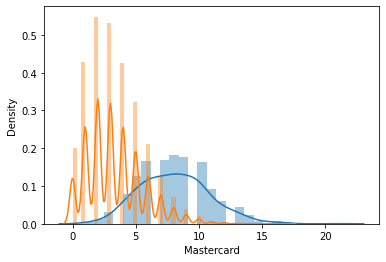

In [35]:
sns.distplot(users_count[users_count['quartilebased_suspicious_flag'] == 1]['Mastercard'])
sns.distplot(users_count[users_count['quartilebased_suspicious_flag'] == 0]['Mastercard'])

In [36]:
users_count['overall_velocity'] = 0

for user in users_count['user_id'].tolist():

  user_len = len(df.loc[df['user_id'] == user])
  delta_t = (df.loc[df['user_id'] == user].iloc[-1, 2] -
             df.loc[df['user_id'] == user].iloc[0, 2]).days

  if delta_t != 0:

    users_count.loc[users_count['user_id'] == user, ['overall_velocity']] = user_len/delta_t

  else:
    users_count.loc[users_count['user_id'] == user, ['overall_velocity']] = user_len

  if user % 5000 == 0: print(user)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000


In [37]:
 users_count.head()

,user_id,total_transactions,quartilebased_suspicious_flag,Discover,JCB_15,JCB_16,Maestro,Mastercard,american_express,diners_club,visa_13,visa_16,visa_19,overall_velocity
0,0,21,0,0.0,1.0,5.0,0.0,0.0,5.0,1.0,2.0,5.0,2.0,21.000000
1,1,51,0,4.0,2.0,12.0,4.0,5.0,3.0,4.0,4.0,9.0,4.0,7.285714
2,2,63,0,4.0,7.0,11.0,4.0,7.0,6.0,3.0,5.0,13.0,3.0,7.875000
3,3,17,0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.428571
4,4,65,0,4.0,4.0,13.0,8.0,3.0,8.0,7.0,4.0,9.0,5.0,8.125000


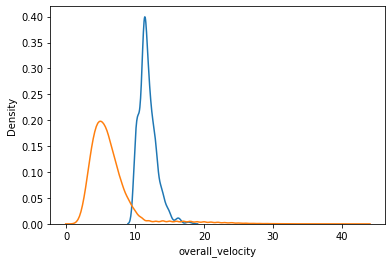

In [38]:
sns.kdeplot(users_count.loc[users_count['quartilebased_suspicious_flag'] == 1]['overall_velocity'])
sns.kdeplot(users_count.loc[users_count['quartilebased_suspicious_flag'] == 0]['overall_velocity'])

In [39]:
users_count.to_csv(os.path.join(BASE_DIR, "users_count.csv"), index=False)

In [ ]:
users_count = pd.read_csv("users_count.csv")

In [40]:
users_count.head()

,user_id,total_transactions,quartilebased_suspicious_flag,Discover,JCB_15,JCB_16,Maestro,Mastercard,american_express,diners_club,visa_13,visa_16,visa_19,overall_velocity
0,0,21,0,0.0,1.0,5.0,0.0,0.0,5.0,1.0,2.0,5.0,2.0,21.000000
1,1,51,0,4.0,2.0,12.0,4.0,5.0,3.0,4.0,4.0,9.0,4.0,7.285714
2,2,63,0,4.0,7.0,11.0,4.0,7.0,6.0,3.0,5.0,13.0,3.0,7.875000
3,3,17,0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.428571
4,4,65,0,4.0,4.0,13.0,8.0,3.0,8.0,7.0,4.0,9.0,5.0,8.125000


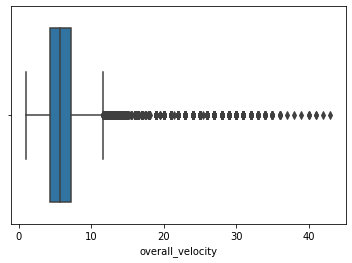

In [41]:
sns.boxplot(x=users_count['overall_velocity']);

In [42]:
#Calculate interquartilic range for outlier detection
IQR_ovr = users_count['overall_velocity'].quantile(0.75) - users_count['overall_velocity'].quantile(0.25)

ovr_iqr_inf_limit = users_count['overall_velocity'].quantile(0.25) - (IQR_ovr * 1.5)
ovr_iqr_sup_limit = users_count['overall_velocity'].quantile(0.75) + (IQR_ovr * 1.5)

print('1st Quartile - 1.5 * DIR = {}'.format(ovr_iqr_inf_limit))
print('3rd Quartile + 1.5 * DIR = {}\n'.format(ovr_iqr_sup_limit))

1st Quartile - 1.5 * DIR = 0.008928571428571175
3rd Quartile + 1.5 * DIR = 11.651785714285715



In [43]:
print('There are {} users with more than 11 transactions/day'.format(
    len([x for x in users_count['overall_velocity'].tolist() if x > ovr_iqr_sup_limit])))

print('There are {} users with less than 0.008 transactions/day'.format(
    len([x for x in users_count['overall_velocity'].tolist() if x < ovr_iqr_inf_limit])))

There are 6184 users with more than 11 transactions/day
There are 0 users with less than 0.008 transactions/day


In [44]:
users_count['ovrvelocity_suspicious_flag'] = np.where(users_count['overall_velocity'] > ovr_iqr_sup_limit, 1, 0)

In [45]:
##THIS ALGORITHM CALCULATES THE AVERAGE TRANSACTION VELOCITY PER HOUR

users_count['avg_hourly_velocity'] = 0

for user in users_count['user_id'].tolist():

  a = df.loc[df['user_id'] == user].copy()

  count = 0
  for day in a.current_day.unique():

    count += len(a[a['current_day'] == day])/len(
        a[a['current_day'] == day].current_hour.unique())

    #print(day, len(a[a['current_day'] == day])/len(a[a['current_day'] == day].current_hour.unique()))

  users_count.loc[users_count['user_id'] == user, 
                  ['avg_hourly_velocity']] = count/len(a.current_day.unique())
  
  if user % 5000 == 0: print(user)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000


In [46]:
users_count.to_csv(os.path.join(BASE_DIR, "users_profile.csv"), index=False)

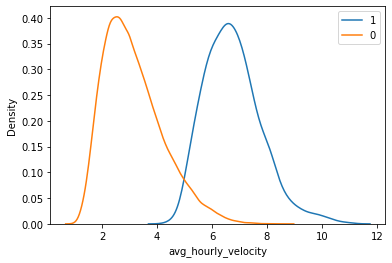

In [47]:
sns.kdeplot(users_count[users_count['quartilebased_suspicious_flag'] == 1]['avg_hourly_velocity'], label='1')
sns.kdeplot(users_count[users_count['quartilebased_suspicious_flag'] == 0]['avg_hourly_velocity'], label='0')
plt.legend()

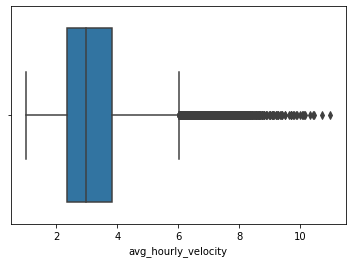

In [48]:
sns.boxplot(x=users_count['avg_hourly_velocity']);

In [49]:
#Calculate interquartilic range for outlier detection
IQR_hour = users_count['avg_hourly_velocity'].quantile(0.75) - users_count['avg_hourly_velocity'].quantile(0.25)

hour_iqr_inf_limit = users_count['avg_hourly_velocity'].quantile(0.25) - (IQR_hour * 1.5)
hour_iqr_sup_limit = users_count['avg_hourly_velocity'].quantile(0.75) + (IQR_hour * 1.5)

print('1st Quartile - 1.5 * DIR = {}'.format(hour_iqr_inf_limit))
print('3rd Quartile + 1.5 * DIR = {}\n'.format(hour_iqr_sup_limit))

1st Quartile - 1.5 * DIR = 0.10833333333333384
3rd Quartile + 1.5 * DIR = 6.041666666666666



In [50]:
print('There are {} users with more than 6 transactions/hour'.format(
    len([x for x in users_count['avg_hourly_velocity'].tolist() if x > hour_iqr_sup_limit])))

print('There are {} users with less than 0.1 transactions/hour'.format(
    len([x for x in users_count['avg_hourly_velocity'].tolist() if x < hour_iqr_inf_limit])))

There are 2177 users with more than 6 transactions/hour
There are 0 users with less than 0.1 transactions/hour


In [51]:
users_count['hourvelocity_suspicious_flag'] = np.where(users_count['avg_hourly_velocity'] > hour_iqr_sup_limit, 1, 0)

In [52]:
users_count

,user_id,total_transactions,quartilebased_suspicious_flag,Discover,JCB_15,JCB_16,Maestro,Mastercard,american_express,diners_club,visa_13,visa_16,visa_19,overall_velocity,ovrvelocity_suspicious_flag,avg_hourly_velocity,hourvelocity_suspicious_flag
0,0,21,0,0.0,1.0,5.0,0.0,0.0,5.0,1.0,2.0,5.0,2.0,21.000000,1,3.833333,0
1,1,51,0,4.0,2.0,12.0,4.0,5.0,3.0,4.0,4.0,9.0,4.0,7.285714,0,3.683333,0
2,2,63,0,4.0,7.0,11.0,4.0,7.0,6.0,3.0,5.0,13.0,3.0,7.875000,0,4.600000,0
3,3,17,0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.428571,0,1.500000,0
4,4,65,0,4.0,4.0,13.0,8.0,3.0,8.0,7.0,4.0,9.0,5.0,8.125000,0,5.400000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,63,0,7.0,7.0,8.0,5.0,3.0,4.0,7.0,5.0,11.0,6.0,7.875000,0,4.200000,0
99996,99997,64,0,6.0,8.0,11.0,6.0,3.0,8.0,2.0,7.0,6.0,7.0,8.000000,0,4.840000,0
99997,99998,40,0,0.0,3.0,6.0,4.0,2.0,5.0,0.0,6.0,8.0,6.0,5.000000,0,2.393333,0
99998,99999,30,0,3.0,3.0,5.0,2.0,0.0,8.0,1.0,1.0,3.0,4.0,5.000000,0,2.866667,0


In [53]:
users_count['hourvelocity_suspicious_flag'].value_counts()

0    97823
1     2177
Name: hourvelocity_suspicious_flag, dtype: int64

In [54]:
users_count.loc[(users_count['quartilebased_suspicious_flag'] == 1) & 
                (users_count['ovrvelocity_suspicious_flag'] == 1) & 
                (users_count['hourvelocity_suspicious_flag'] == 1)]

,user_id,total_transactions,quartilebased_suspicious_flag,Discover,JCB_15,JCB_16,Maestro,Mastercard,american_express,diners_club,visa_13,visa_16,visa_19,overall_velocity,ovrvelocity_suspicious_flag,avg_hourly_velocity,hourvelocity_suspicious_flag
58,58,106,1,10.0,13.0,14.0,7.0,9.0,6.0,8.0,10.0,20.0,9.0,13.250000,1,8.760000,1
125,125,107,1,12.0,12.0,17.0,4.0,3.0,10.0,10.0,7.0,25.0,7.0,13.375000,1,7.900000,1
194,194,107,1,9.0,6.0,13.0,13.0,14.0,9.0,8.0,11.0,11.0,13.0,13.375000,1,8.033333,1
830,830,91,1,8.0,4.0,13.0,8.0,8.0,9.0,11.0,9.0,15.0,6.0,13.000000,1,8.133333,1
1283,1283,109,1,8.0,11.0,24.0,7.0,8.0,4.0,7.0,12.0,24.0,4.0,13.625000,1,8.040000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98858,98859,130,1,9.0,6.0,25.0,13.0,10.0,8.0,14.0,14.0,16.0,15.0,16.250000,1,9.106667,1
98979,98980,110,1,7.0,11.0,22.0,10.0,15.0,4.0,15.0,8.0,9.0,9.0,13.750000,1,7.766667,1
99028,99029,93,1,6.0,14.0,13.0,11.0,13.0,6.0,3.0,4.0,12.0,11.0,13.285714,1,8.000000,1
99154,99155,101,1,11.0,8.0,16.0,9.0,8.0,10.0,7.0,7.0,18.0,7.0,12.625000,1,7.260000,1


In [55]:
users_count.to_csv(os.path.join(BASE_DIR, "users_profile.csv"), index=False)